# <div style="color:white;display:fill;border-radius:10px;background-color:#8ABEB9;overflow:hidden"><p style="padding:20px;color:WHITE;overflow:hidden;font-size:75%;margin:0;text-align:CENTER">Team 05 - Flower recoginition with CNN </p></div>

In [3]:
# Importing all the useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the Keras libraries and packages
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from PIL import Image

from keras.regularizers import l2
from keras.layers import Dense,Dropout,BatchNormalization
from keras import regularizers

import glob as glob
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras import applications
from keras.applications.resnet import ResNet50

In [2]:
# Visualkeras to visualize the model

!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 32.9 MB/s eta 0:00:00


In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
# Creating a train test split and put it in folders

# Set the folder path and the class names

folder_path = '/kaggle/input/flowers-recognition/flowers'
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Create train and test directories
train_dir = './train'
test_dir = './test'
for dir_path in [train_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for class_name in class_names:
        if not os.path.exists(os.path.join(dir_path, class_name)):
            os.makedirs(os.path.join(dir_path, class_name))

# Move images to train and test directories
for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    file_names = os.listdir(class_path)
    train_files, test_files = train_test_split(file_names, test_size=0.2)
    for file_name in train_files:
        src_path = os.path.join(class_path, file_name)
        dst_path = os.path.join(train_dir, class_name, file_name)
        shutil.copy(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(class_path, file_name)
        dst_path = os.path.join(test_dir, class_name, file_name)
        shutil.copy(src_path, dst_path)

In [6]:
# Count the number of files in the train directory for each class

for class_name in class_names:

    # Train data
    train_class_path = os.path.join(train_dir, class_name)
    num_train_files = len(os.listdir(train_class_path))
    # Test data
    test_class_path = os.path.join(test_dir, class_name)
    num_test_files = len(os.listdir(test_class_path))
    print(f"Total no. of {class_name} flowers:",num_train_files+num_test_files,f"-- Train: {num_train_files} Test: {num_test_files}")



Total no. of daisy flowers: 764 -- Train: 611 Test: 153
Total no. of dandelion flowers: 1052 -- Train: 841 Test: 211
Total no. of rose flowers: 784 -- Train: 627 Test: 157
Total no. of sunflower flowers: 733 -- Train: 586 Test: 147
Total no. of tulip flowers: 984 -- Train: 787 Test: 197


Image shape: (320, 263, 3)


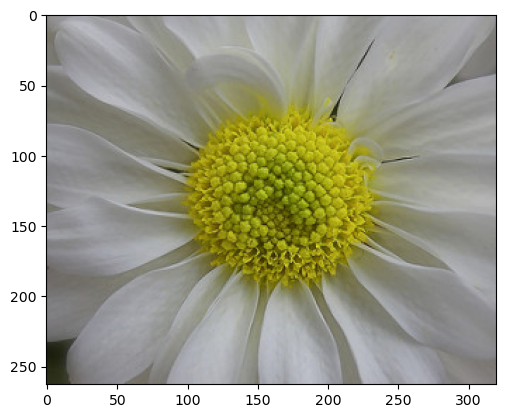

In [8]:
## Lets visualize a sample image

# Open the image
img = Image.open("/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg")

# # Get the dimensions of the image
width, height = img.size

# # Get the number of color channels in the image
num_channels = len(img.getbands())

# # Print the image shape
print("Image shape: ({}, {}, {})".format(width, height, num_channels))

plt.imshow(img)
plt.show()

In [8]:
# Initial insight about the shapes - This daisy flower image having a shape of (320,232,3)

## Building a basic CNN model with 3 convolutional layers

### First lets use the parameters of basic configurations and then we'll experiment to find how the hyper parameters affects

In [11]:
# Initialising the CNN
classifier = Sequential()

# 32 filters each of size 3,3
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu', kernel_regularizer=l2(0.01)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 64 filters each of size 3,3
classifier.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.01)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 64 filters each of size 3,3
classifier.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.01)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 5, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# Fitting the CNN to the images

K.clear_session()

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  # Only rescaling; no data augmentation should be done in test 

# Flow from directory is the file loaded from the directory

# Since there are 5 labels - class_mode - categorical

train_gen = train_datagen.flow_from_directory('./train',target_size = (128, 128),batch_size = 32, class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory('./test',target_size = (128, 128), batch_size = 32, class_mode = 'categorical', shuffle=False)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [1]:
3452+865

4317

### Lets visualize the filters used in our first convolution layer

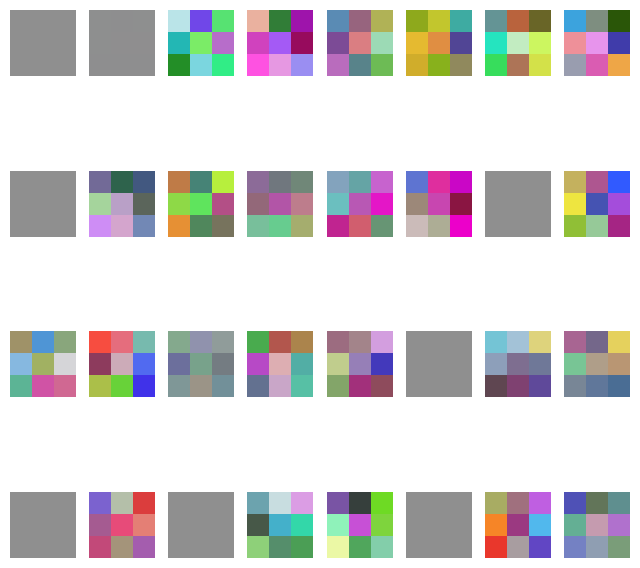

In [19]:
# Get the first convolutional layer
layer = classifier.get_layer(index=0)

# Get the filters from the layer
filters = layer.get_weights()[0]

# Normalize the filters
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot the filters 
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[:, :, :, i], cmap='gray')
    ax.set_axis_off()
plt.show()                  # As 32 filters were used in the 1st layer - in 4 rows 8 cols we'll visualize them

### Totally 32 filters each of size 3 * 3 

### Let's look how our model has been built with 3 convolution layers

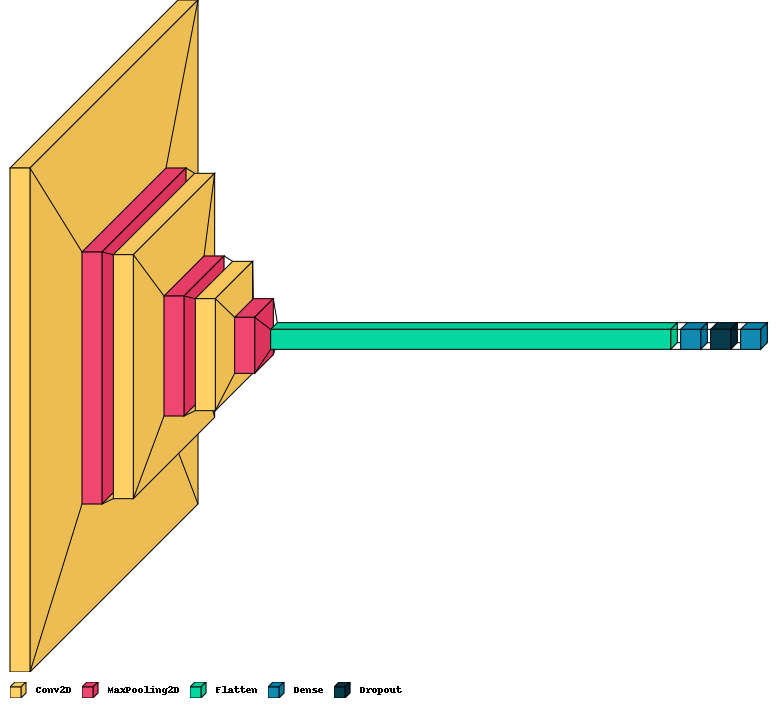

In [20]:
visualkeras.layered_view(classifier, legend=True,draw_volume=True)

In [21]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

### About the parameters ...

1. conv2d (Conv2D) layer: (None, 126, 126, 32) output shape. Here None refers to the batch size. $(126,126)$ is because $n\times n$ image, here $128\times 128$ dimensional image with $k \times k = 3 \times 3 $ dimensional filters leads to  $ n-f+1 = 126-3+1 = 126 $ i.e., $ 126 \times 126 $ dimensional image. $32$ is the number of filters applied. Number of parameters = $ 896 $ = ((width of filter * height filter * number of channels)+1) * number of filters = $ ((3*3*3)+1)*32 = (27+1)*32 = 896.$


2. max_pooling2d (MaxPooling2D): (None, 63, 63, 32) output shape. $63 \times 63$ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((126-2)/2)+1 \rfloor = \lfloor 62+1 \rfloor = \lfloor 63 \rfloor = 63.$ Here $W$ is the input size, $F$ is the kernel size and $S$ is the stride size. 32 is the number of filters from the previous layer.

3. conv2d_1 (Conv2D) layer: (None, 61, 61, 64) output shape. $(61,61)$ is because $n\times n$ image, here $63\times 63$ dimensional image(becuase of Max pooling) with $k \times k = 3 \times 3 $ dimensional filters leads to  $ 61 \times 61 $ dimensional image. $64$ is the number of filters applied. Number of parameters = $ 18496 $ = ((width of filter*height filter *  number of filters in the previous layer)+1)* number of filters = $ ((3*3*32)+1)*64 = (288+1)*64 = 18496.$

4. max_pooling2d_1 (MaxPooling2D): (None, 30, 30, 64) output shape. $30 \times 30$ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((61-2)/2)+1 \rfloor = \lfloor 29.5+1 \rfloor = \lfloor 30.5 \rfloor = 30,$ and $64$ corresponds to the number of filters in the previous conv2d_1 layer, which was set to $64.$ 

5. conv2d_2 (Conv2D) layer: (None, 28, 28, 64) output shape. $(28,28)$ is because $n\times n$ image, here $30\times 30$ dimensional image(becuase of Max pooling) with $k \times k = 3 \times 3 $ dimensional filters leads to  $ 28 \times 28 $ dimensional image. $64$ is the number of filters applied. Number of parameters = $ 36928 $ = ((width of filter*height filter * number of filters in the previous layer)+1)* number of filters = $ ((3*3*64)+1)*64 = (576+1)*64 = 36928.$

6. max_pooling2d_2 (MaxPooling2d): (None, 14, 14, 64) output shape. $14 \times 14$ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((28-2)/2)+1 \rfloor = \lfloor 13+1 \rfloor = \lfloor 14 \rfloor = 14,$ and $64$ is because of the number of filters in the previous layer.


7. flatten (Flatten): (None, 12544) output shape. $12544 = 14*14*64 $


8. dense (Dense) layer: (None, 128) output shape. $ 128 $ is the number of neurons in the dense layer and $1605760$ is the number of parametes = $(12544*128 ) + 128 = 1605632 + 128  = 1605760 .$

9. dropout (Dropout): (None, 128) output shape. The dropout layer in this case takes the output of the dense layer, which has shape (None, 128). Dropout value chosen is $0.2$

10. dense_1 (Dense) layer (output layer): (None, 5) output shape. The dense_1 layer is the output layer of the neural network, which has $5$ neurons. In this case, the neural network is designed to perform a classification task with $5$ possible classes, so the output layer has $5$ neurons, one for each possible class. The number of parameters is $645$ because $(128*5) + 5.$

In [13]:
# Fitting the classfier 
hist = classifier.fit(train_gen, epochs =15, validation_data = test_gen)

Epoch 1/15
108/108 [==============================] - 31s 216ms/step - loss: 1.7457 - accuracy: 0.4548 - val_loss: 1.3746 - val_accuracy: 0.5468
Epoch 2/15
108/108 [==============================] - 23s 209ms/step - loss: 1.3067 - accuracy: 0.5591 - val_loss: 1.2097 - val_accuracy: 0.5803
Epoch 3/15
108/108 [==============================] - 23s 212ms/step - loss: 1.1640 - accuracy: 0.6176 - val_loss: 1.1024 - val_accuracy: 0.6116
Epoch 4/15
108/108 [==============================] - 23s 213ms/step - loss: 1.0923 - accuracy: 0.6304 - val_loss: 1.1262 - val_accuracy: 0.6439
Epoch 5/15
108/108 [==============================] - 23s 213ms/step - loss: 1.0429 - accuracy: 0.6463 - val_loss: 1.0942 - val_accuracy: 0.6208
Epoch 6/15
108/108 [==============================] - 23s 210ms/step - loss: 1.0298 - accuracy: 0.6512 - val_loss: 1.0599 - val_accuracy: 0.6116
Epoch 7/15
108/108 [==============================] - 23s 213ms/step - loss: 0.9609 - accuracy: 0.6813 - val_loss: 0.9945 - val_ac

28/28 [==============================] - 2s 87ms/step

Confusion matrix
 [[ 97  22  26   1   7]
 [ 18 146  23  19   5]
 [  7   7 113   2  28]
 [  2  16   8 117   4]
 [  9   9  70   7 102]]

Test accuracy: 0.6647398843930635


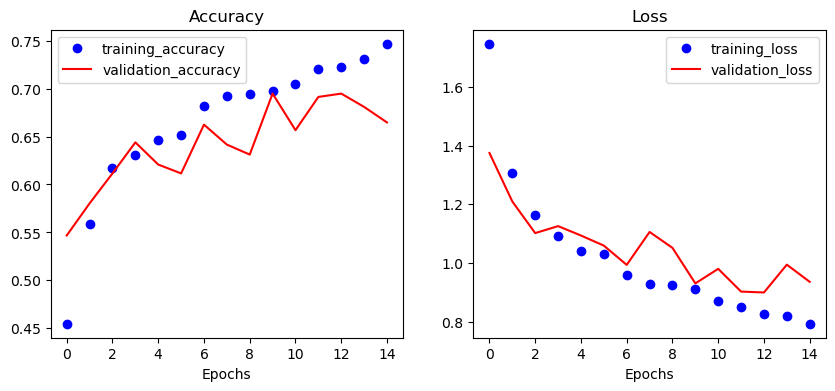

In [16]:
# Defining a function to measure the model performance and plot performance charts
def model_results(model_name,hist=hist):

    y_test = test_gen.classes
    yt_prob = model_name.predict(test_gen)
    yt_pred = np.argmax(yt_prob, axis=1)

    print("\nConfusion matrix\n",confusion_matrix(y_test, yt_pred))
    print("\nTest accuracy:",accuracy_score(y_test, yt_pred))

    # Plot of performance charts against epochs
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'],'bo')
    plt.plot(hist.history['val_accuracy'],'r')
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.legend(['training_accuracy','validation_accuracy'],loc='best')
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], 'bo')
    plt.plot(hist.history['val_loss'],'r')
    plt.xlabel('Epochs')
    plt.title('Loss')
    plt.legend(['training_loss','validation_loss'])
    plt.show()
    return None

model_results(classifier)

<b> Observation

     The test accuracy of the above basic CNN model is not great.. This can be improvized further by choosing the best / hyperparameter tuning.

### Let's experiment to deep dive about the parameters

### Creating an user defined function to tune the hyperparameters of CNN model

In [31]:
def create_cnn(num_conv_layers, num_filters, filter_size, num_dense_layers, num_nodes, dropout_rate):
    # Initialize Classifier
    
    K.clear_session()
    classifier = Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
       
        classifier.add(Conv2D(num_filters, filter_size, activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)))
        classifier.add(BatchNormalization())
        classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Flatten layer
    classifier.add(Flatten())
    
    # Add dense layers
    for i in range(num_dense_layers):
        classifier.add(Dense(units = num_nodes, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        classifier.add(Dropout(dropout_rate))
                    
    # Output layer
    classifier.add(Dense(units = 5, activation = 'softmax'))

    # Compile CNN
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Part 2 - Fitting the CNN to the images
    #K.clear_session()

    train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,
                                       zoom_range = 0.2, horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale = 1./255)  # Only rescaling no data augmentation should be done in test 

    train_gen = train_datagen.flow_from_directory('./train',
                            target_size = (224,224),batch_size = 32, class_mode = 'categorical')
    # Flow from directory is the file loaded from the directory
    test_gen = test_datagen.flow_from_directory('./test',
                            target_size = (224,224), batch_size = 32, class_mode = 'categorical', shuffle=False)


    hist = classifier.fit(train_gen, epochs =10,validation_data = test_gen)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'],'bo')
    plt.plot(hist.history['val_accuracy'],'r')
    plt.xlabel('No.of epochs')
    plt.title('Accuracy')
    plt.legend(['training_accuracy','validation_accuracy'],loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], 'bo')
    plt.plot(hist.history['val_loss'],'r')
    plt.xlabel('No.of epochs')
    plt.title('Loss')
    plt.legend(['training_loss','validation_loss'])
    plt.show()

    return hist

In [32]:
# Defining a class to highlight text 

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Experiment 1 - Performance of model with varying convolution layers

No.of Convolution layers used: 1

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 59s 436ms/step - loss: 22.1608 - accuracy: 0.3602 - val_loss: 10.3938 - val_accuracy: 0.2923
Epoch 2/10
131/131 [==============================] - 56s 431ms/step - loss: 6.8605 - accuracy: 0.4287 - val_loss: 5.0542 - val_accuracy: 0.2568
Epoch 3/10
131/131 [==============================] - 58s 441ms/step - loss: 4.3830 - accuracy: 0.4741 - val_loss: 4.1134 - val_accuracy: 0.4471
Epoch 4/10
131/131 [==============================] - 57s 437ms/step - loss: 4.0659 - accuracy: 0.4986 - val_loss: 4.2942 - val_accuracy: 0.4680
Epoch 5/10
131/131 [==============================] - 57s 439ms/step - loss: 4.4112 - accuracy: 0.5060 - val_loss: 4.5805 - val_accuracy: 0.5352
Epoch 6/10
131/131 [==============================] - 58s 441ms/step - loss: 4.6587 - accuracy: 0.5065 - val_loss: 4.1810 - val_accuracy: 0.5802
Epoch 7/10

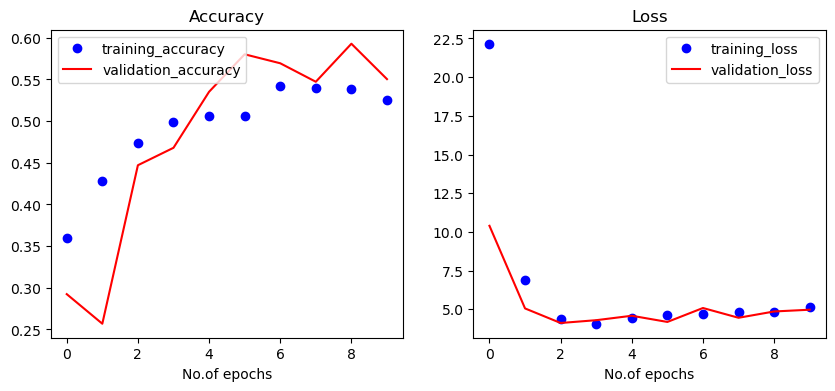

No.of Convolution layers used: 2

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 60s 438ms/step - loss: 11.8541 - accuracy: 0.3552 - val_loss: 15.8379 - val_accuracy: 0.2181
Epoch 2/10
131/131 [==============================] - 59s 448ms/step - loss: 6.6475 - accuracy: 0.3240 - val_loss: 13.0014 - val_accuracy: 0.2067
Epoch 3/10
131/131 [==============================] - 57s 437ms/step - loss: 4.7398 - accuracy: 0.3244 - val_loss: 5.5485 - val_accuracy: 0.3234
Epoch 4/10
131/131 [==============================] - 58s 440ms/step - loss: 4.0248 - accuracy: 0.3540 - val_loss: 3.7368 - val_accuracy: 0.3862
Epoch 5/10
131/131 [==============================] - 58s 441ms/step - loss: 3.8059 - accuracy: 0.3386 - val_loss: 3.9838 - val_accuracy: 0.3450
Epoch 6/10
131/131 [==============================] - 57s 437ms/step - loss: 3.8359 - accuracy: 0.3638 - val_loss: 3.5081 - val_accuracy: 0.4724
Epoch 7/1

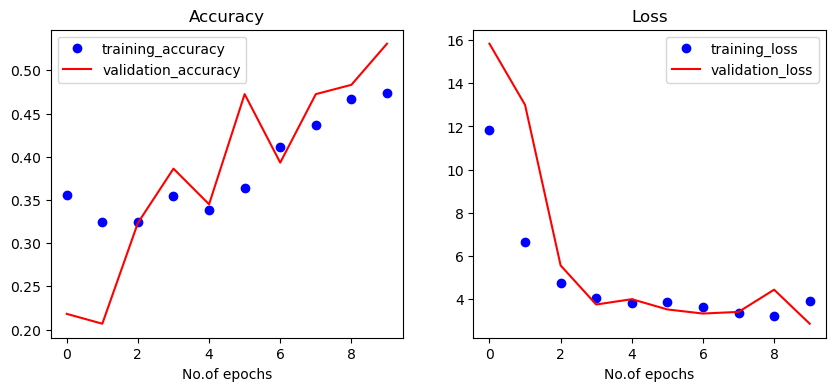

No.of Convolution layers used: 3

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 61s 441ms/step - loss: 6.1537 - accuracy: 0.4116 - val_loss: 7.6003 - val_accuracy: 0.2486
Epoch 2/10
131/131 [==============================] - 58s 442ms/step - loss: 4.1353 - accuracy: 0.4661 - val_loss: 4.1935 - val_accuracy: 0.3158
Epoch 3/10
131/131 [==============================] - 57s 437ms/step - loss: 3.2603 - accuracy: 0.5144 - val_loss: 4.1557 - val_accuracy: 0.3773
Epoch 4/10
131/131 [==============================] - 57s 435ms/step - loss: 2.7540 - accuracy: 0.5524 - val_loss: 2.6581 - val_accuracy: 0.5587
Epoch 5/10
131/131 [==============================] - 57s 437ms/step - loss: 2.4482 - accuracy: 0.5802 - val_loss: 2.3279 - val_accuracy: 0.6056
Epoch 6/10
131/131 [==============================] - 57s 432ms/step - loss: 2.1507 - accuracy: 0.6306 - val_loss: 2.6092 - val_accuracy: 0.4914
Epoch 7/10
1

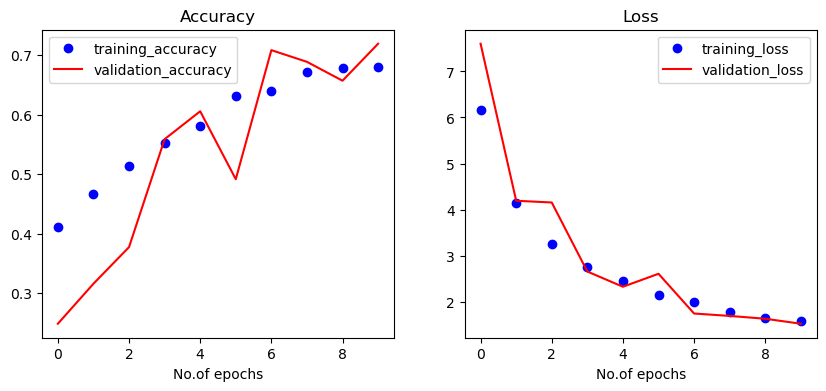

,Convolution_layers,Test_accuracy
0,1,0.550412
1,2,0.530755
2,3,0.719087


In [33]:
# configuration to try # 
config = {'num_conv_layers': i, 'num_filters': 32, 'filter_size': (3, 3), 'num_dense_layers': 2, 'num_nodes': 128, 'dropout_rate': 0.1}

# Create CNN with configuration
accuracy_values=[]
layers=[1,2,3]
for i in layers:
    print(color.BOLD + f'No.of Convolution layers used: {i}' + color.END)
    print()
    cnn = create_cnn(i, config['num_filters'], config['filter_size'], 
                     config['num_dense_layers'], config['num_nodes'], config['dropout_rate'])

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'Convolution_layers':layers,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * 3 no.of layers has got good accuracy from the experiment. Increaseing from 1 to 3 is more beneficial.
    * Adding more layers will helps to extract more features. 
    * But it can be experimented till a certain extent. 
    * After that, instead of extracting features, we tend to ‘overfit’ the data. 
    * Overfitting can lead to also produce more false positive results.
    
    For ex: In the recognition of cats, overfitted model learns even the bell in the cats neck.
            If any other animal comes with bell, model may classify that as cat.(False positives)

## Experiment 2 - Performance of model with varying no.of filters

No.of filters used: 32

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 93s 434ms/step - loss: 6.4719 - accuracy: 0.3893 - val_loss: 6.8212 - val_accuracy: 0.2739
Epoch 2/10
131/131 [==============================] - 57s 436ms/step - loss: 4.3237 - accuracy: 0.4743 - val_loss: 4.3887 - val_accuracy: 0.2188
Epoch 3/10
131/131 [==============================] - 56s 431ms/step - loss: 3.4041 - accuracy: 0.5163 - val_loss: 3.8191 - val_accuracy: 0.3418
Epoch 4/10
131/131 [==============================] - 58s 441ms/step - loss: 2.8153 - accuracy: 0.5521 - val_loss: 2.7445 - val_accuracy: 0.5485
Epoch 5/10
131/131 [==============================] - 58s 443ms/step - loss: 2.4395 - accuracy: 0.6136 - val_loss: 2.3193 - val_accuracy: 0.5999
Epoch 6/10
131/131 [==============================] - 58s 442ms/step - loss: 2.2528 - accuracy: 0.6107 - val_loss: 2.2063 - val_accuracy: 0.5656
Epoch 7/10
131/131 [==

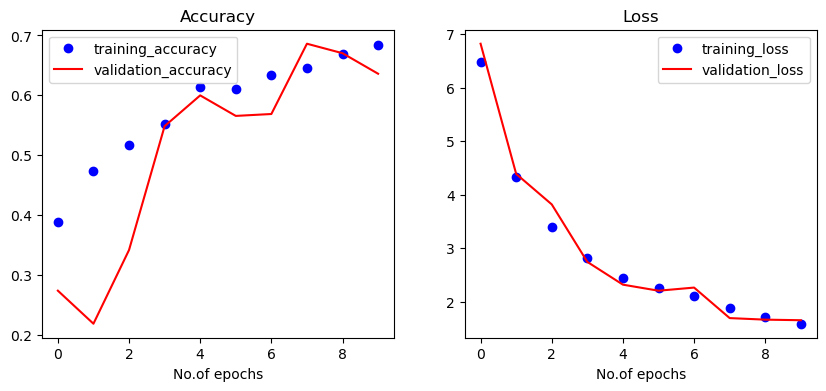

No.of filters used: 64

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 62s 451ms/step - loss: 9.4451 - accuracy: 0.3744 - val_loss: 7.5626 - val_accuracy: 0.1978
Epoch 2/10
131/131 [==============================] - 64s 492ms/step - loss: 6.4153 - accuracy: 0.3725 - val_loss: 6.3570 - val_accuracy: 0.3145
Epoch 3/10
131/131 [==============================] - 60s 454ms/step - loss: 4.6419 - accuracy: 0.4133 - val_loss: 4.2243 - val_accuracy: 0.4027
Epoch 4/10
131/131 [==============================] - 59s 454ms/step - loss: 3.8061 - accuracy: 0.4392 - val_loss: 3.7988 - val_accuracy: 0.4020
Epoch 5/10
131/131 [==============================] - 59s 449ms/step - loss: 3.4803 - accuracy: 0.4436 - val_loss: 3.3109 - val_accuracy: 0.4864
Epoch 6/10
131/131 [==============================] - 59s 450ms/step - loss: 3.1791 - accuracy: 0.4829 - val_loss: 2.8155 - val_accuracy: 0.5371
Epoch 7/10
131/131 [==

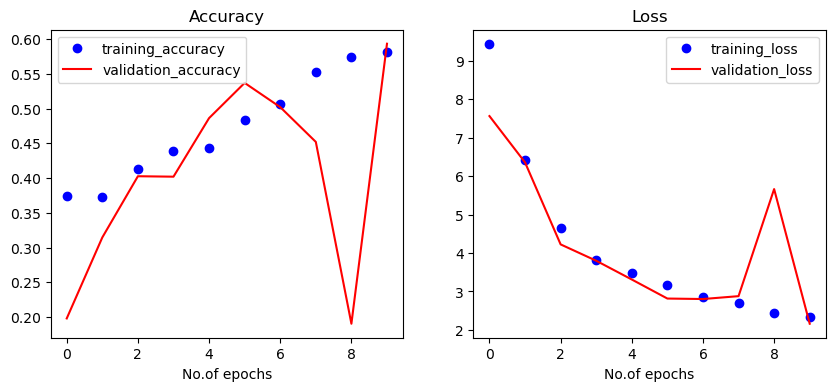

No.of filters used: 128

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 66s 487ms/step - loss: 15.1047 - accuracy: 0.3480 - val_loss: 11.1150 - val_accuracy: 0.3107
Epoch 2/10
131/131 [==============================] - 63s 482ms/step - loss: 9.2721 - accuracy: 0.3249 - val_loss: 8.7006 - val_accuracy: 0.3088
Epoch 3/10
131/131 [==============================] - 68s 517ms/step - loss: 6.0163 - accuracy: 0.3422 - val_loss: 6.8409 - val_accuracy: 0.2803
Epoch 4/10
131/131 [==============================] - 64s 484ms/step - loss: 5.0158 - accuracy: 0.3535 - val_loss: 5.3484 - val_accuracy: 0.3462
Epoch 5/10
131/131 [==============================] - 64s 487ms/step - loss: 4.3080 - accuracy: 0.3648 - val_loss: 3.6560 - val_accuracy: 0.3976
Epoch 6/10
131/131 [==============================] - 63s 482ms/step - loss: 3.5363 - accuracy: 0.3833 - val_loss: 3.6084 - val_accuracy: 0.3500
Epoch 7/10
131/131 

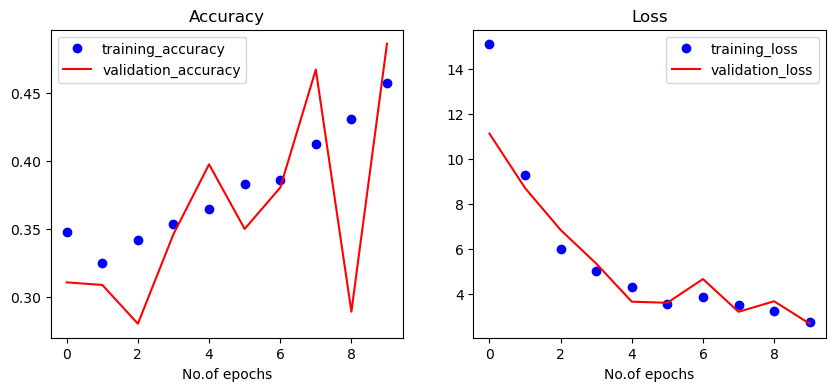

,No.of_filters,Test_accuracy
0,32,0.636018
1,64,0.593532
2,128,0.486367


In [34]:
# configuration to try # 
config = {'num_conv_layers': 3, 'num_filters': i, 'filter_size': (3, 3), 'num_dense_layers': 2, 'num_nodes': 128, 'dropout_rate': 0.1}

# Create CNN with configuration
accuracy_values=[]
filters=[32,64,128]
for i in filters:
    print(color.BOLD + f'No.of filters used: {i}' + color.END)
    print()
    cnn = create_cnn(config['num_conv_layers'], i, config['filter_size'], 
                     config['num_dense_layers'], config['num_nodes'], config['dropout_rate'])

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'No.of_filters':filters,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * In the above experiment, 32 filters model has got good accuracy compared to others.
    * Higher the no.of filters, higher is the no.of abstractions that model can extract from the imaage. 
    * Usually, the number of filters is generally ascending since at the input layer the Network receives raw pixel         data. 
    * Raw data are always noisy, and this is especially true for image data. 
    * We let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. 
    * Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

## Experiment 3 - Performance of model with varying filters size

Size of the filter used: (3, 3)

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 60s 431ms/step - loss: 6.1894 - accuracy: 0.4316 - val_loss: 10.0713 - val_accuracy: 0.2479
Epoch 2/10
131/131 [==============================] - 57s 433ms/step - loss: 4.2057 - accuracy: 0.4664 - val_loss: 4.9392 - val_accuracy: 0.2834
Epoch 3/10
131/131 [==============================] - 58s 441ms/step - loss: 3.1972 - accuracy: 0.5286 - val_loss: 3.1155 - val_accuracy: 0.4566
Epoch 4/10
131/131 [==============================] - 57s 436ms/step - loss: 2.7671 - accuracy: 0.5622 - val_loss: 3.0801 - val_accuracy: 0.4667
Epoch 5/10
131/131 [==============================] - 57s 432ms/step - loss: 2.4368 - accuracy: 0.5985 - val_loss: 2.3246 - val_accuracy: 0.6005
Epoch 6/10
131/131 [==============================] - 56s 430ms/step - loss: 2.1466 - accuracy: 0.6412 - val_loss: 2.0552 - val_accuracy: 0.6443
Epoch 7/10
1

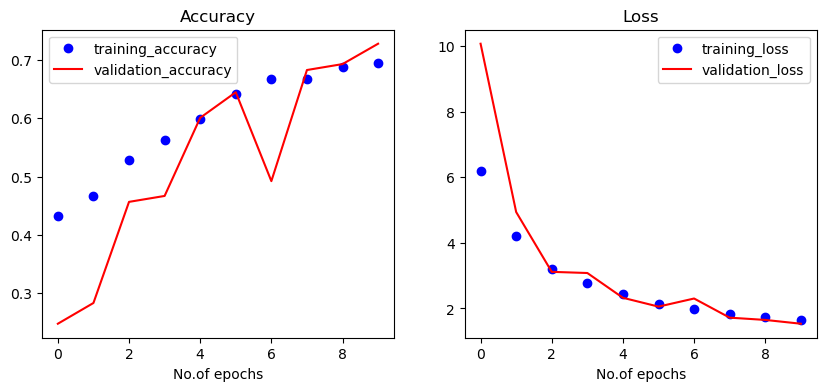

Size of the filter used: (5, 5)

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 60s 434ms/step - loss: 6.5048 - accuracy: 0.3802 - val_loss: 6.4342 - val_accuracy: 0.2524
Epoch 2/10
131/131 [==============================] - 57s 435ms/step - loss: 4.5058 - accuracy: 0.4652 - val_loss: 3.9261 - val_accuracy: 0.4198
Epoch 3/10
131/131 [==============================] - 57s 438ms/step - loss: 3.4317 - accuracy: 0.4938 - val_loss: 3.0425 - val_accuracy: 0.4832
Epoch 4/10
131/131 [==============================] - 58s 441ms/step - loss: 2.8259 - accuracy: 0.5202 - val_loss: 3.1408 - val_accuracy: 0.3735
Epoch 5/10
131/131 [==============================] - 58s 442ms/step - loss: 2.4222 - accuracy: 0.5536 - val_loss: 2.7232 - val_accuracy: 0.4534
Epoch 6/10
131/131 [==============================] - 58s 440ms/step - loss: 2.1700 - accuracy: 0.5780 - val_loss: 2.4805 - val_accuracy: 0.5225
Epoch 7/10
13

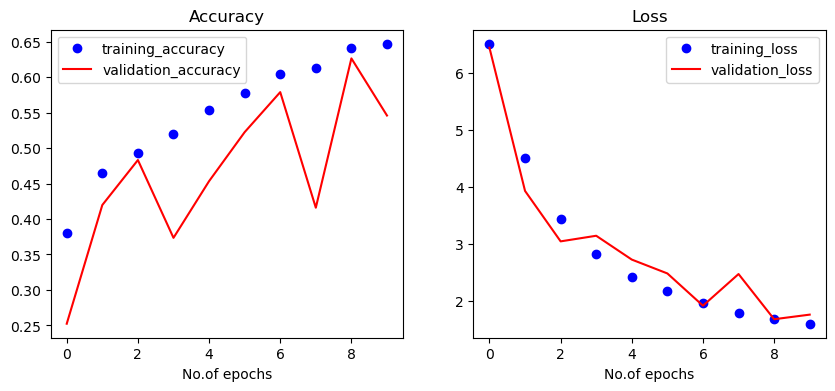

Size of the filter used: (7, 7)

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 63s 449ms/step - loss: 6.4766 - accuracy: 0.3840 - val_loss: 5.4878 - val_accuracy: 0.3285
Epoch 2/10
131/131 [==============================] - 58s 445ms/step - loss: 4.5841 - accuracy: 0.4693 - val_loss: 3.9887 - val_accuracy: 0.4597
Epoch 3/10
131/131 [==============================] - 58s 442ms/step - loss: 3.3970 - accuracy: 0.5168 - val_loss: 3.0637 - val_accuracy: 0.4927
Epoch 4/10
131/131 [==============================] - 58s 439ms/step - loss: 2.6800 - accuracy: 0.5488 - val_loss: 2.7536 - val_accuracy: 0.4794
Epoch 5/10
131/131 [==============================] - 57s 437ms/step - loss: 2.2979 - accuracy: 0.5817 - val_loss: 2.7133 - val_accuracy: 0.3963
Epoch 6/10
131/131 [==============================] - 58s 442ms/step - loss: 2.0202 - accuracy: 0.6078 - val_loss: 1.9455 - val_accuracy: 0.6119
Epoch 7/10
13

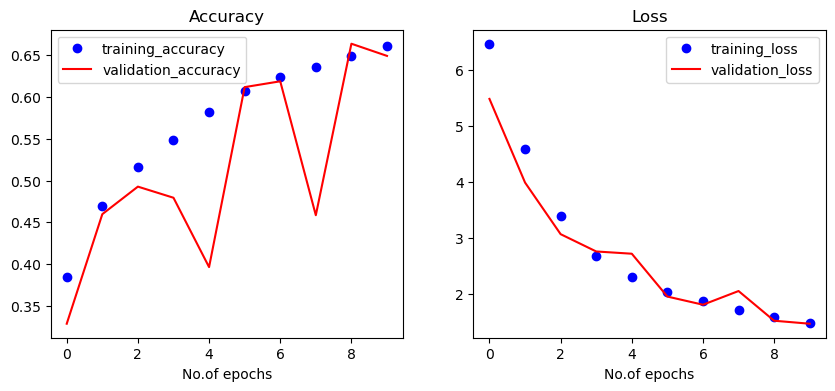

,Size_of_the_filters,Test_accuracy
0,"(3, 3)",0.727330
1,"(5, 5)",0.545973
2,"(7, 7)",0.649334


In [35]:
# configuration to try # 
config = {'num_conv_layers': 3, 'num_filters': 32, 'filter_size': i, 'num_dense_layers': 2, 'num_nodes': 128, 'dropout_rate': 0.1}

# Create CNN with configuration
accuracy_values=[]
filter_size=[(3,3),(5,5),(7,7)]
for i in filter_size:
    print(color.BOLD + f'Size of the filter used: {i}' + color.END)
    print()
    cnn = create_cnn(config['num_conv_layers'], config['num_filters'], i, 
                     config['num_dense_layers'], config['num_nodes'], config['dropout_rate'])

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'Size_of_the_filters':filter_size,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * (3,3) filter size has got the highest accuracy in the above experiment.
    * (5,5) and (7,7) filter size used models accuracy were fluctuating up and down.
    * Generally in the initial layers of a CNN, a smaller filter size is preferred, as it can capture low-level features     such as edges and corners. 
    * A larger filter size can capture more complex patterns and features in the input image, but it can also increase  the number of parameters in the model, leading to overfitting and slower training. 
    * In the flower recognition, the data size is not that large. So using a (3,3) filter size would be convenient.

## Experiment 4 - Performance of model with varying number of dense layers

Number of dense layers: 1

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 60s 434ms/step - loss: 5.4599 - accuracy: 0.4462 - val_loss: 8.5115 - val_accuracy: 0.2714
Epoch 2/10
131/131 [==============================] - 57s 438ms/step - loss: 3.3893 - accuracy: 0.5132 - val_loss: 4.6776 - val_accuracy: 0.3101
Epoch 3/10
131/131 [==============================] - 57s 433ms/step - loss: 2.6717 - accuracy: 0.5569 - val_loss: 2.9719 - val_accuracy: 0.4065
Epoch 4/10
131/131 [==============================] - 57s 437ms/step - loss: 2.3456 - accuracy: 0.5768 - val_loss: 2.3725 - val_accuracy: 0.5003
Epoch 5/10
131/131 [==============================] - 57s 433ms/step - loss: 1.9288 - accuracy: 0.6290 - val_loss: 2.0458 - val_accuracy: 0.6030
Epoch 6/10
131/131 [==============================] - 58s 440ms/step - loss: 2.0150 - accuracy: 0.6328 - val_loss: 2.5375 - val_accuracy: 0.5606
Epoch 7/10
131/131 

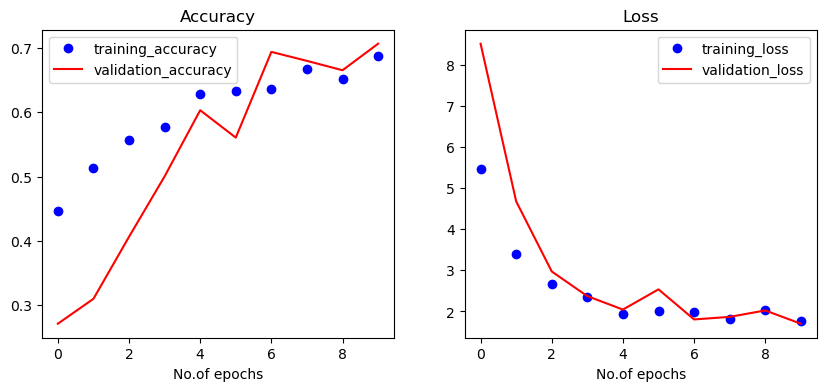

Number of dense layers: 2

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 65s 478ms/step - loss: 6.2822 - accuracy: 0.4414 - val_loss: 6.0000 - val_accuracy: 0.2397
Epoch 2/10
131/131 [==============================] - 58s 440ms/step - loss: 4.2763 - accuracy: 0.5195 - val_loss: 5.4635 - val_accuracy: 0.3012
Epoch 3/10
131/131 [==============================] - 58s 444ms/step - loss: 3.3495 - accuracy: 0.5490 - val_loss: 3.1366 - val_accuracy: 0.4952
Epoch 4/10
131/131 [==============================] - 58s 446ms/step - loss: 2.7612 - accuracy: 0.5992 - val_loss: 2.6274 - val_accuracy: 0.5466
Epoch 5/10
131/131 [==============================] - 58s 442ms/step - loss: 2.3937 - accuracy: 0.6153 - val_loss: 2.1595 - val_accuracy: 0.6576
Epoch 6/10
131/131 [==============================] - 58s 444ms/step - loss: 2.1158 - accuracy: 0.6441 - val_loss: 1.9736 - val_accuracy: 0.6709
Epoch 7/10
131/131 

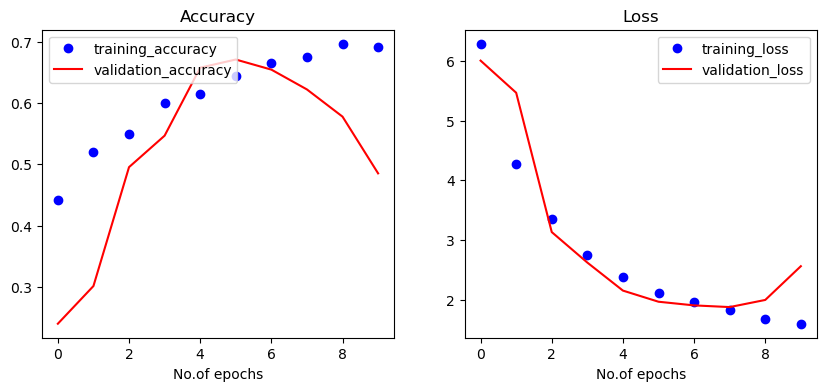

Number of dense layers: 3

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 62s 447ms/step - loss: 6.9619 - accuracy: 0.4236 - val_loss: 6.0797 - val_accuracy: 0.2581
Epoch 2/10
131/131 [==============================] - 58s 444ms/step - loss: 4.6893 - accuracy: 0.5082 - val_loss: 4.3889 - val_accuracy: 0.3462
Epoch 3/10
131/131 [==============================] - 57s 436ms/step - loss: 3.6421 - accuracy: 0.5351 - val_loss: 3.4363 - val_accuracy: 0.4566
Epoch 4/10
131/131 [==============================] - 58s 442ms/step - loss: 2.9601 - accuracy: 0.5944 - val_loss: 3.2723 - val_accuracy: 0.4274
Epoch 5/10
131/131 [==============================] - 57s 437ms/step - loss: 2.5395 - accuracy: 0.6328 - val_loss: 2.3479 - val_accuracy: 0.6506
Epoch 6/10
131/131 [==============================] - 57s 435ms/step - loss: 2.2515 - accuracy: 0.6482 - val_loss: 2.3326 - val_accuracy: 0.5954
Epoch 7/10
131/131 

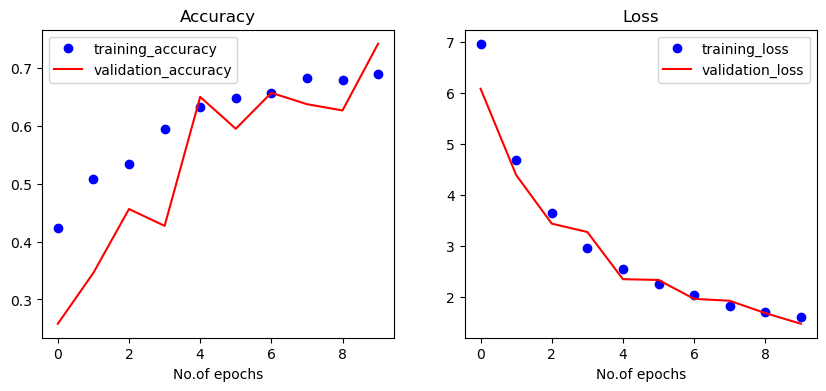

,No.of_dense_layers,Test_accuracy
0,1,0.706405
1,2,0.485098
2,3,0.742549


In [36]:
# configuration to try # 
config = {'num_conv_layers': 3, 'num_filters': 32, 'filter_size': (3,3), 'num_dense_layers': i, 'num_nodes': 128, 'dropout_rate': 0.1}

# Create CNN with configuration
accuracy_values=[]
dense_layers=[1,2,3]
for i in dense_layers:
    print(color.BOLD + f'Number of dense layers: {i}' + color.END)
    print()
    cnn = create_cnn(config['num_conv_layers'], config['num_filters'],config['filter_size'], 
                     i, config['num_nodes'], config['dropout_rate'])

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'No.of_dense_layers':dense_layers,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * Here, there is no linear relationship between No. of dense layers added and accuracy.
    * Dense layer 3 has got slighter more accuracy that 1 whereas the accuracy of model with 2 dense layers started dipping after few epochs.
    * Thus, it is generally recommended to start with a small number of dense layers and gradually increase the complexity  of the model if necessary. 
    * This approach helps to prevent overfitting and ensures that the model is not unnecessarily complex.

## Experiment 5 - Performance of model with varying number of nodes

Number of nodes: 128

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 61s 441ms/step - loss: 6.0998 - accuracy: 0.4083 - val_loss: 7.0113 - val_accuracy: 0.2460
Epoch 2/10
131/131 [==============================] - 58s 441ms/step - loss: 3.9897 - accuracy: 0.4993 - val_loss: 3.9938 - val_accuracy: 0.2701
Epoch 3/10
131/131 [==============================] - 59s 447ms/step - loss: 3.1176 - accuracy: 0.5377 - val_loss: 3.2023 - val_accuracy: 0.4109
Epoch 4/10
131/131 [==============================] - 59s 448ms/step - loss: 2.7410 - accuracy: 0.5564 - val_loss: 2.5579 - val_accuracy: 0.5802
Epoch 5/10
131/131 [==============================] - 58s 446ms/step - loss: 2.4712 - accuracy: 0.6047 - val_loss: 2.4404 - val_accuracy: 0.5542
Epoch 6/10
131/131 [==============================] - 58s 443ms/step - loss: 2.2080 - accuracy: 0.6419 - val_loss: 2.1270 - val_accuracy: 0.6126
Epoch 7/10
131/131 [====

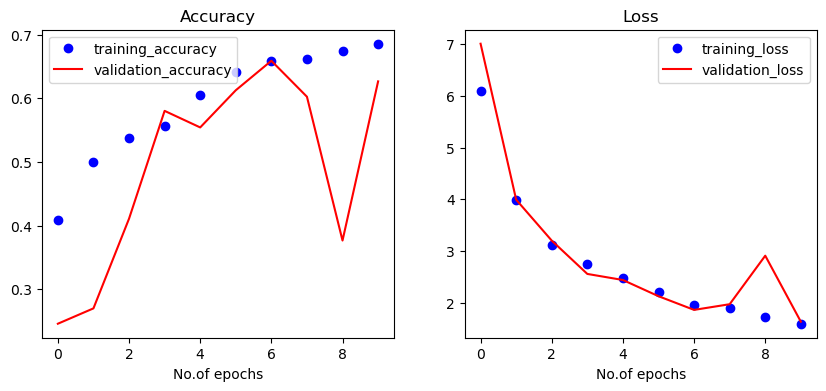

Number of nodes: 256

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 61s 446ms/step - loss: 9.2659 - accuracy: 0.4277 - val_loss: 8.9985 - val_accuracy: 0.2479
Epoch 2/10
131/131 [==============================] - 58s 446ms/step - loss: 5.1740 - accuracy: 0.5007 - val_loss: 5.7893 - val_accuracy: 0.2689
Epoch 3/10
131/131 [==============================] - 58s 444ms/step - loss: 3.8618 - accuracy: 0.5413 - val_loss: 3.8161 - val_accuracy: 0.4965
Epoch 4/10
131/131 [==============================] - 59s 447ms/step - loss: 3.2337 - accuracy: 0.6078 - val_loss: 2.9336 - val_accuracy: 0.5859
Epoch 5/10
131/131 [==============================] - 58s 443ms/step - loss: 2.7474 - accuracy: 0.6292 - val_loss: 2.5483 - val_accuracy: 0.6665
Epoch 6/10
131/131 [==============================] - 58s 443ms/step - loss: 2.4438 - accuracy: 0.6455 - val_loss: 2.2287 - val_accuracy: 0.6690
Epoch 7/10
131/131 [====

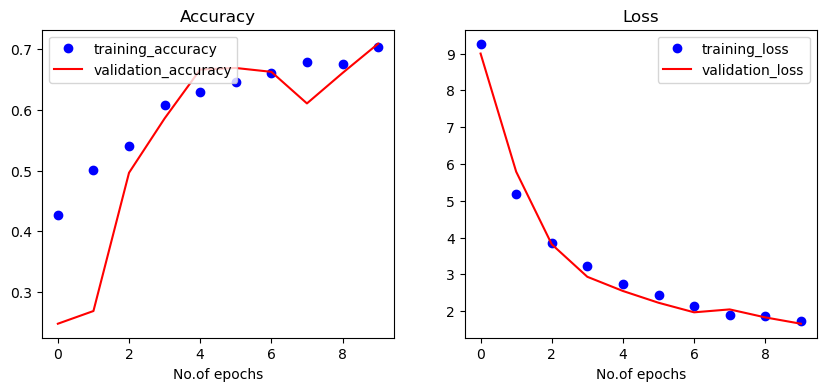

Number of nodes: 512

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 62s 451ms/step - loss: 15.3002 - accuracy: 0.4450 - val_loss: 11.7913 - val_accuracy: 0.2479
Epoch 2/10
131/131 [==============================] - 59s 447ms/step - loss: 7.1920 - accuracy: 0.5223 - val_loss: 6.3917 - val_accuracy: 0.3114
Epoch 3/10
131/131 [==============================] - 58s 446ms/step - loss: 4.8176 - accuracy: 0.5586 - val_loss: 4.2310 - val_accuracy: 0.4483
Epoch 4/10
131/131 [==============================] - 59s 446ms/step - loss: 3.4562 - accuracy: 0.6081 - val_loss: 3.1292 - val_accuracy: 0.5897
Epoch 5/10
131/131 [==============================] - 59s 447ms/step - loss: 2.8757 - accuracy: 0.6323 - val_loss: 2.8578 - val_accuracy: 0.5720
Epoch 6/10
131/131 [==============================] - 58s 445ms/step - loss: 2.5059 - accuracy: 0.6398 - val_loss: 2.4079 - val_accuracy: 0.5973
Epoch 7/10
131/131 [==

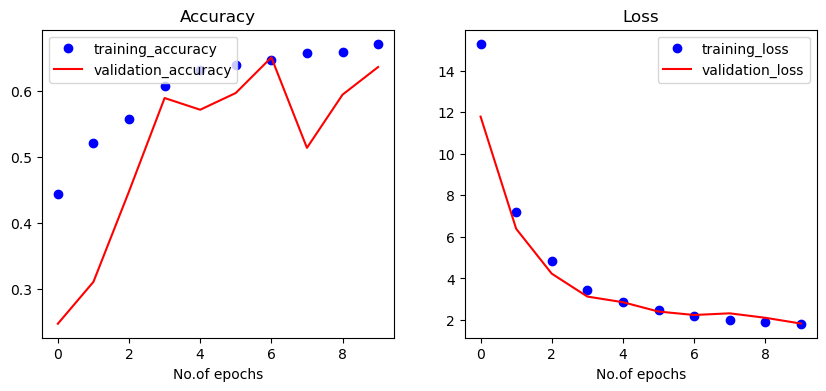

,No.of_nodes,Test_accuracy
0,128,0.626506
1,256,0.708941
2,512,0.636652


In [37]:
# configuration to try # 
config = {'num_conv_layers': 3, 'num_filters': 32, 'filter_size': (3,3), 'num_dense_layers': 2, 'num_nodes': i, 'dropout_rate': 0.1}

# Create CNN with configuration
accuracy_values=[]
nodes=[128,256,512]
for i in nodes:
    print(color.BOLD + f'Number of nodes: {i}' + color.END)
    print()
    cnn = create_cnn(config['num_conv_layers'], config['num_filters'],config['filter_size'], 
                     config['num_dense_layers'], i, config['dropout_rate'])

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'No.of_nodes':nodes,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * 128 nodes - 62% accuracy
    * whereas 256 nodes in the dense layer produced 70% accuracy
    * when tried to increase the nodes to 512,the performance started dipping.    
    * Increasing the number of nodes in the dense layer(s) can increase the model's capacity to learn complex patterns and relationships in the data, but it can also lead to overfitting and slower training. 
    * Conversely, decreasing the number of nodes can reduce the model's capacity and may not capture all the relevant patterns in the data.
    * Thus, it is generally recommended to choose no.of nodes based on the complexity of the problem, the amount of data available, and the size of the input data.

## Experiment 6 - Performance of model with varying dropout rates

Dropout_rate: 0.1

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 62s 443ms/step - loss: 6.3315 - accuracy: 0.3982 - val_loss: 6.9235 - val_accuracy: 0.2517
Epoch 2/10
131/131 [==============================] - 58s 445ms/step - loss: 4.1958 - accuracy: 0.4856 - val_loss: 5.3583 - val_accuracy: 0.2663
Epoch 3/10
131/131 [==============================] - 58s 445ms/step - loss: 3.2175 - accuracy: 0.5303 - val_loss: 3.0714 - val_accuracy: 0.4845
Epoch 4/10
131/131 [==============================] - 59s 447ms/step - loss: 2.6654 - accuracy: 0.5584 - val_loss: 2.5221 - val_accuracy: 0.5897
Epoch 5/10
131/131 [==============================] - 58s 442ms/step - loss: 2.4071 - accuracy: 0.5891 - val_loss: 2.2263 - val_accuracy: 0.6075
Epoch 6/10
131/131 [==============================] - 59s 447ms/step - loss: 2.2044 - accuracy: 0.6117 - val_loss: 1.9990 - val_accuracy: 0.6576
Epoch 7/10
131/131 [=======

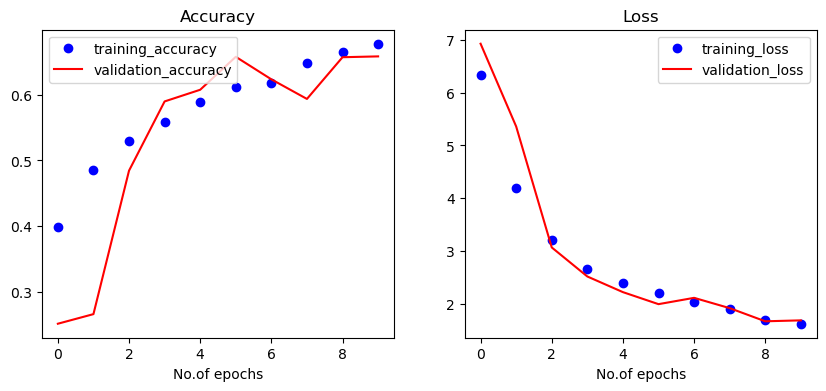

Dropout_rate: 0.2

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 61s 442ms/step - loss: 6.7357 - accuracy: 0.3720 - val_loss: 11.4588 - val_accuracy: 0.2479
Epoch 2/10
131/131 [==============================] - 58s 444ms/step - loss: 4.6477 - accuracy: 0.4284 - val_loss: 5.3862 - val_accuracy: 0.2765
Epoch 3/10
131/131 [==============================] - 58s 444ms/step - loss: 3.6249 - accuracy: 0.4484 - val_loss: 3.7792 - val_accuracy: 0.4096
Epoch 4/10
131/131 [==============================] - 58s 441ms/step - loss: 3.1022 - accuracy: 0.5077 - val_loss: 2.9081 - val_accuracy: 0.5130
Epoch 5/10
131/131 [==============================] - 58s 443ms/step - loss: 2.7046 - accuracy: 0.5423 - val_loss: 2.5744 - val_accuracy: 0.5422
Epoch 6/10
131/131 [==============================] - 59s 447ms/step - loss: 2.5176 - accuracy: 0.5550 - val_loss: 2.3212 - val_accuracy: 0.5967
Epoch 7/10
131/131 [======

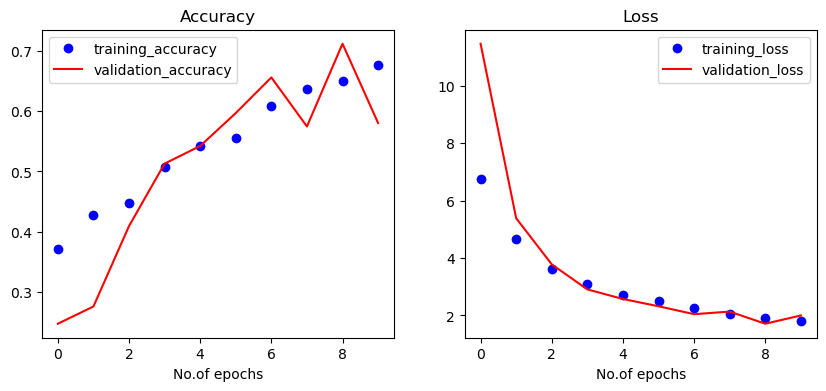

Dropout_rate: 0.3

Found 4164 images belonging to 5 classes.
Found 1577 images belonging to 5 classes.
Epoch 1/10
131/131 [==============================] - 61s 443ms/step - loss: 7.0261 - accuracy: 0.3280 - val_loss: 5.9030 - val_accuracy: 0.2492
Epoch 2/10
131/131 [==============================] - 58s 446ms/step - loss: 4.7741 - accuracy: 0.3542 - val_loss: 4.2191 - val_accuracy: 0.3323
Epoch 3/10
131/131 [==============================] - 58s 444ms/step - loss: 3.7532 - accuracy: 0.3650 - val_loss: 3.7084 - val_accuracy: 0.3557
Epoch 4/10
131/131 [==============================] - 58s 445ms/step - loss: 3.0901 - accuracy: 0.4239 - val_loss: 2.6276 - val_accuracy: 0.4959
Epoch 5/10
131/131 [==============================] - 58s 442ms/step - loss: 2.7343 - accuracy: 0.4503 - val_loss: 2.5472 - val_accuracy: 0.5022
Epoch 6/10
131/131 [==============================] - 58s 442ms/step - loss: 2.5179 - accuracy: 0.4868 - val_loss: 2.5676 - val_accuracy: 0.4718
Epoch 7/10
131/131 [=======

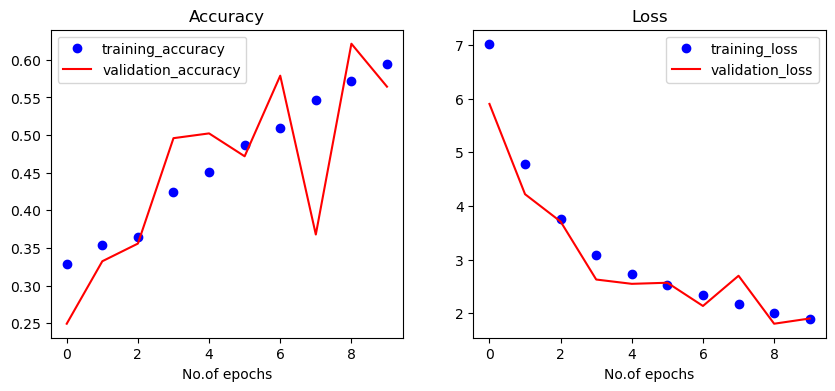

,Dropout_rate,Test_accuracy
0,0.1,0.658212
1,0.2,0.580216
2,0.3,0.564363


In [38]:
# configuration to try # 
config = {'num_conv_layers': 3, 'num_filters': 32, 'filter_size': (3,3), 'num_dense_layers': 2, 'num_nodes': 128, 'dropout_rate': i}

# Create CNN with configuration
accuracy_values=[]
drop_out=[0.1,0.2,0.3]
for i in drop_out:
    print(color.BOLD + f'Dropout_rate: {i}' + color.END)
    print()
    cnn = create_cnn(config['num_conv_layers'], config['num_filters'],config['filter_size'], 
                     config['num_dense_layers'], config['num_nodes'], i)

    accuracy=cnn.history['val_accuracy'][-1]
    accuracy_values.append(accuracy)
    
results_df=pd.DataFrame({'Dropout_rate':drop_out,'Test_accuracy':accuracy_values})
results_df

<b> Observations:
    
    * Here, increasing the dropout rate, classification accuracy drops.
    * A high dropout rate can lead to underfitting, as the model may not have enough capacity to learn the relevant patterns in the data.
    * On the other hand, decreasing the dropout rate can increase the model's capacity to learn complex patterns, but it    can also lead to overfitting.
    * Generally, it is recommended to start with a low dropout rate (e.g., 0.1 or 0.2) and gradually increase it until the  model's performance on the validation set stops improving or starts to degrade.

### We'll try out our findings to build the best CNN model

### Final Model with best parameters after multiple hyper parameter tuning trails

In [81]:
# Initialising the CNN
classifier = Sequential()

# 32 filters each of size 3,3
classifier.add(Conv2D(32, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 64 filters each of size 3,3
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 128 filters each of size 3,3
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dense(units = 5, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

<b> From the understanding of the above experiments, 

        * <b> No.of convolution/pooling layers chosen as 3
        * <b> Different no.of filters all with a size of 3*3 were used in each convolution layers. 
    
        Layer1 - 32     
        Layer2 - 64
        Layer3 - 128

        * <b> Increased the input shape of the image to (256,256) for better learning.
        * <b> No of units/nodes in final dense layer chosen as 512.
        * <b> Increased the no.of epochs to 15.
        * <b> Reduced the batch size to 25.

### Let's look how our model has been built with 3 convolution layers

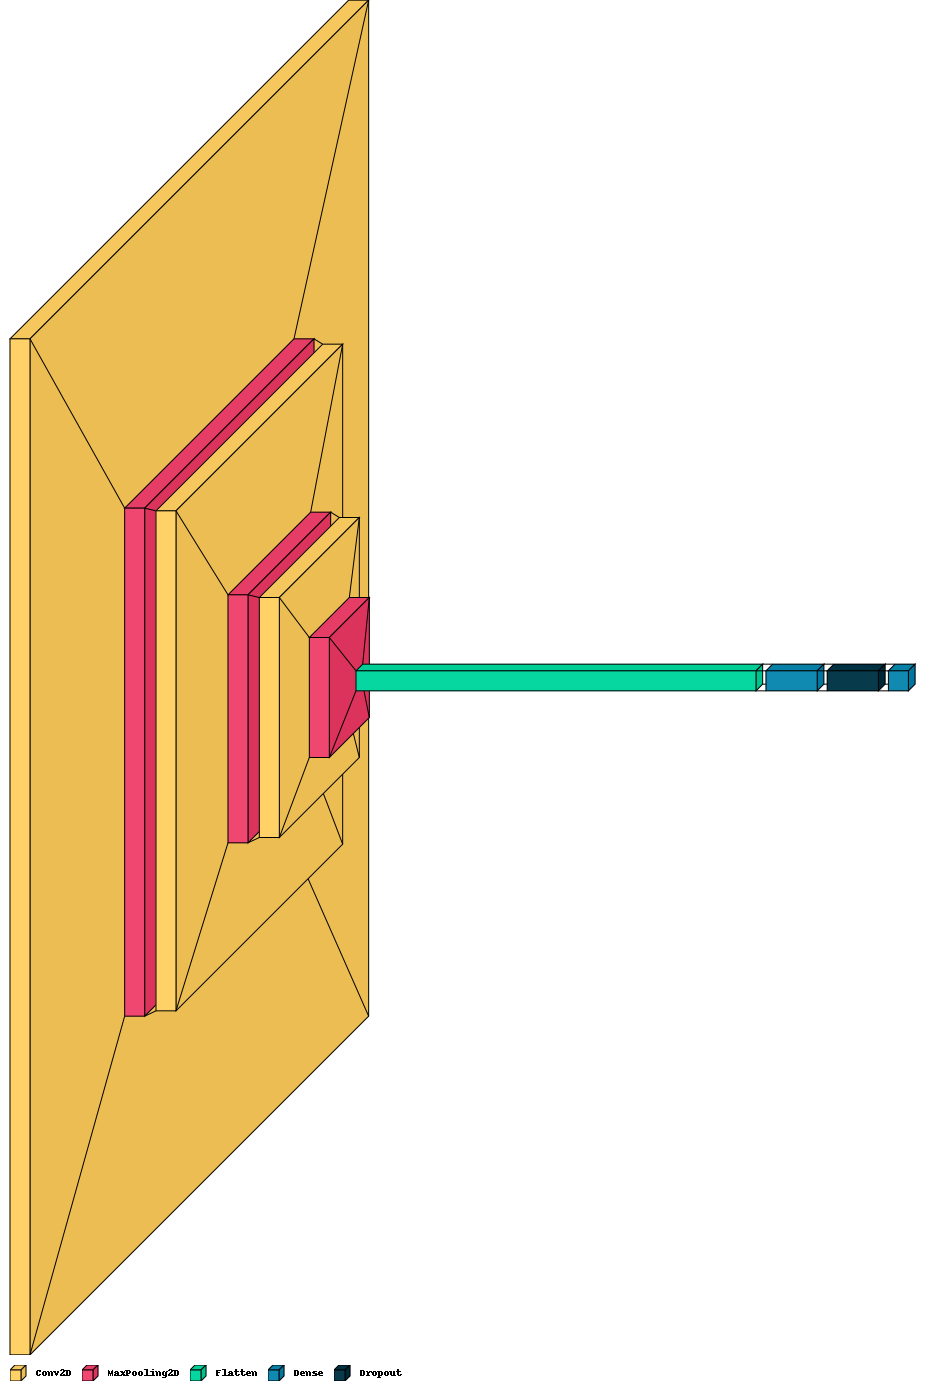

In [36]:
visualkeras.layered_view(classifier, legend=True,draw_volume=True)

In [82]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

### <b> About the parameters ...

1. conv2d_3 (Conv2D) layer: (None, 254, 254, 32) output shape.  Here None refers to the batch size. $(254,254)$ is because $n\times n$ image, here $256\times 256$ dimensional image with $k \times k = 3 \times 3 $ dimensional filters leads to  $ n-f+1 = 256-3+1 = 254 $ i.e., $ 254 \times 254 $ dimensional image. $32$ is the number of filters applied. Number of parameters = $ 896 $ = ((width of filter * height filter * number of channels)+1) * number of filters = $ ((3*3*3)+1)*32 = (27+1)*32 = 896.$

2. max_pooling2d_3 (MaxPooling2D): (None, 127, 127, 32) output shape. $127 \times 127$ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((254-2)/2)+1 \rfloor = \lfloor 126+1 \rfloor = \lfloor 127 \rfloor = 127.$ Here $W$ is the input size, $F$ is the kernel size and $S$ is the stride size. 32 is the number of filters from the previous layer. 32 is the number of filters in the previous layer.





3. conv2d_4 (Conv2D) layer: (None, 125, 125, 64) output shape. $(125,125)$ is because $n\times n$ image, here $127\times 127$ dimensional image(becuase of Max pooling) with $k \times k = 3 \times 3 $ dimensional filters leads to  $ 125 \times 125 $ dimensional image. $64$ is the number of filters applied. Number of parameters = $ 18496 $ = ((width of filter*height filter *  number of filters in the previous layer)+1)* number of filters = $ ((3*3*32)+1)*64 = (288+1)*64 = 18496.$

4. max_pooling2d_4 (MaxPooling2D): (None, 62, 62, 64) output shape. $62 \times 62$ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((125-2)/2)+1 \rfloor = \lfloor 61.5+1 \rfloor = \lfloor 62.5 \rfloor = 62,$ and $64$ is the number of filters applied in the previous layer.

5. conv2d_5 (Conv2D) layer: (None, 60, 60, 128) output shape. $(60,60)$ is because $n\times n$ image, here $62\times 62$ dimensional image(becuase of Max pooling) with $k \times k = 3 \times 3 $ dimensional filters leads to  $ 60 \times 60 $ dimensional image. $128$ is the number of filters applied. Number of parameters = $ 73856 $ = ((width of filter*height filter *  number of filters in the previous layer)+1)* number of filters = $ ((3*3*64)+1)*128 = (576+1)*128 = 73856.$

6. max_pooling2d_5 (MaxPooling2D) layer: (None, 30, 30, 128) output shape. $30 \times 30 $ is because $\lfloor ((W - F) / S) + 1 \rfloor = \lfloor ((60-2)/2)+1 \rfloor = \lfloor 29+1 \rfloor = \lfloor 30 \rfloor = 30 ,$ and $128$ is the number of filters applied in the previous layer.


7. flatten_1 (Flatten): (None, 115200) output shape. $115200 = 30*30*128 $


8. dense_3 (Dense) layer: (None, 512) output shape. $ 512 $ is the number of neurons in the dense layer and $58982912$ is the number of parametes = $(115200*512 ) + 512 = 58982400 + 512  = 58982912 .$

9. dense_4 (Dense) layer (output layer): (None, 5) output shape. The dense_4 layer is the output layer of the neural network, which has $5$ neurons. In this case, the neural network is designed to perform a classification task with $5$ possible classes, so the output layer has $5$ neurons, one for each possible class. The number of parameters is $2565$  because $(512*5) + 5.$

In [6]:
os.chdir('/kaggle/working/')

In [83]:
# Fitting the CNN to the images

K.clear_session()

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  

# Since there are 5 labels - class_mode - categorical

train_gen = train_datagen.flow_from_directory('./train',target_size = (256, 256),batch_size = 25, class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory('./test',target_size = (256, 256), batch_size = 25, class_mode = 'categorical', shuffle=False)

Found 4130 images belonging to 5 classes.
Found 1543 images belonging to 5 classes.


In [84]:
# Fitting the classifier

hist = classifier.fit(train_gen, epochs =15, validation_data = test_gen)

Epoch 1/15
166/166 [==============================] - 76s 442ms/step - loss: 1.3341 - accuracy: 0.4794 - val_loss: 1.0511 - val_accuracy: 0.5917
Epoch 2/15
166/166 [==============================] - 74s 446ms/step - loss: 0.9748 - accuracy: 0.6160 - val_loss: 0.8510 - val_accuracy: 0.6708
Epoch 3/15
166/166 [==============================] - 73s 438ms/step - loss: 0.8464 - accuracy: 0.6794 - val_loss: 0.7680 - val_accuracy: 0.7045
Epoch 4/15
166/166 [==============================] - 74s 445ms/step - loss: 0.7457 - accuracy: 0.7179 - val_loss: 0.6599 - val_accuracy: 0.7557
Epoch 5/15
166/166 [==============================] - 73s 439ms/step - loss: 0.7004 - accuracy: 0.7349 - val_loss: 0.6355 - val_accuracy: 0.7641
Epoch 6/15
166/166 [==============================] - 72s 434ms/step - loss: 0.6287 - accuracy: 0.7634 - val_loss: 0.5680 - val_accuracy: 0.7861
Epoch 7/15
166/166 [==============================] - 74s 443ms/step - loss: 0.5908 - accuracy: 0.7821 - val_loss: 0.5712 - val_ac

### Visualizing 1st Convolution layer's filters

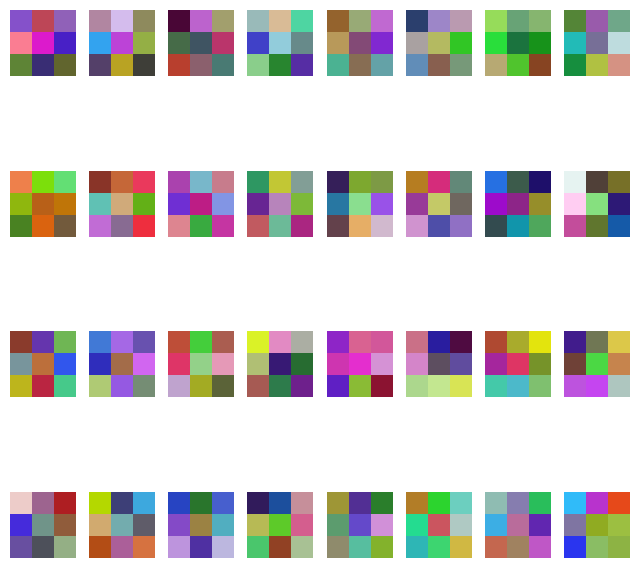

In [85]:
# Get the first convolutional layer
layer = classifier.get_layer(index=0)

# Get the filters from the layer
filters = layer.get_weights()[0]

# Normalize the filters
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot the filters
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[:, :, :, i], cmap='gray')
    ax.set_axis_off()
plt.show()

### Totally 32 filters each of size 3 * 3 

In [86]:
y_test = test_gen.classes

yt_prob = classifier.predict(test_gen)
yt_pred = np.argmax(yt_prob, axis=1)

62/62 [==============================] - 6s 90ms/step


In [87]:
confusion_matrix(y_test, yt_pred)

array([[251,   5,   6,   3,   4],
       [ 15, 312,  10,  33,   0],
       [  4,   6, 262,   1,   9],
       [  0,   3,   3, 257,   2],
       [  2,   3,  12,  14, 326]])

In [88]:
accuracy_score(y_test, yt_pred)

0.9125081011017498

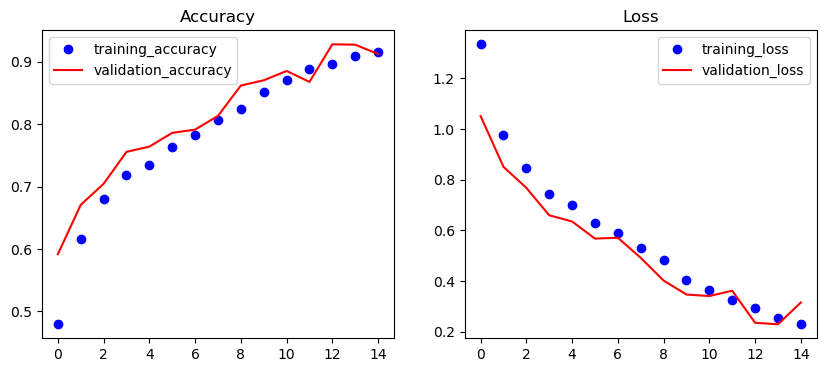

In [89]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],'bo')
plt.plot(hist.history['val_accuracy'],'r')
plt.title('Accuracy')
plt.legend(['training_accuracy','validation_accuracy'],loc='upper left')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], 'bo')
plt.plot(hist.history['val_loss'],'r')
plt.title('Loss')
plt.legend(['training_loss','validation_loss'])
plt.show()

### Observations 

* <b>  After experimenting about the hyperparamters, the best parameters for this model have been chosen.

* <b>  The performance of this complex model is very good compared to our first simple model.

* <b>  Resulted in a training accuracy of 91.5% and test accuracy of 91.2%

# <div style="color:white;display:fill;border-radius:10px;background-color:#8ABEB9;overflow:hidden"><p style="padding:20px;color:WHITE;overflow:hidden;font-size:75%;margin:0;text-align:CENTER">Pretrained Models</p></div>

## 1) VGG16

In [17]:
import glob as glob
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [56]:
K.clear_session()

# Default image processing size in VGG16 - 224
img_size=224

# Input shape 224*224
input_shape = (img_size, img_size, 3)
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory('./train',target_size = (img_size, img_size),batch_size = 32, class_mode = 'categorical')
test_gen = test_datagen.flow_from_directory('./test',target_size = (img_size, img_size), batch_size = 32, class_mode = 'categorical', shuffle=False)

Found 3452 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [57]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace


vgg16_model = VGG16(weights = 'imagenet', include_top = False, input_shape=input_shape)
x = vgg16_model.output                  # include_top = False -> Doesn't include the last ANN part

# Pooling
x = GlobalAveragePooling2D()(x)

# ANN layer
x = Dense(4096, activation='relu')(x)

# Output layer 
predictions = Dense(5, activation = 'softmax')(x)

model = Model(vgg16_model.input, predictions)

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [59]:
# Freeze layers

for layer in vgg16_model.layers:
    layer.trainable = False 
    
# layer.trainable = False -> we need to use existing weights

In [60]:
# Compile the model with adam optimizer

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [61]:
# Model fitting

hist = model.fit(train_gen, epochs = 15, validation_data = test_gen)

Epoch 1/15
108/108 [==============================] - 54s 491ms/step - loss: 0.8895 - accuracy: 0.6570 - val_loss: 0.6320 - val_accuracy: 0.7746
Epoch 2/15
108/108 [==============================] - 53s 490ms/step - loss: 0.6427 - accuracy: 0.7625 - val_loss: 0.5146 - val_accuracy: 0.8289
Epoch 3/15
108/108 [==============================] - 53s 489ms/step - loss: 0.5637 - accuracy: 0.7914 - val_loss: 0.5202 - val_accuracy: 0.8231
Epoch 4/15
108/108 [==============================] - 54s 495ms/step - loss: 0.5205 - accuracy: 0.7998 - val_loss: 0.4497 - val_accuracy: 0.8358
Epoch 5/15
108/108 [==============================] - 53s 489ms/step - loss: 0.4727 - accuracy: 0.8250 - val_loss: 0.4525 - val_accuracy: 0.8439
Epoch 6/15
108/108 [==============================] - 52s 482ms/step - loss: 0.4628 - accuracy: 0.8265 - val_loss: 0.4137 - val_accuracy: 0.8624
Epoch 7/15
108/108 [==============================] - 53s 489ms/step - loss: 0.4465 - accuracy: 0.8337 - val_loss: 0.3955 - val_ac

### Testing for Accuracy

In [62]:
# Model performance on test data

score = model.evaluate(test_gen)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

28/28 [==============================] - 4s 147ms/step - loss: 0.4175 - accuracy: 0.8532
Test Score: 0.41746896505355835
Test Accuracy: 0.8531792163848877


In [ ]:
# 85% test accuracy

In [52]:
# Prediction of classes using probability

y_test = test_gen.classes

yt_prob = model.predict(test_gen)
yt_pred = np.argmax(yt_prob, axis=1)

28/28 [==============================] - 4s 146ms/step


In [53]:
confusion_matrix(y_test, yt_pred)

array([[112,   4,  15,  19,   3],
       [  8, 173,   6,  22,   2],
       [  0,   0, 153,   2,   2],
       [  2,   0,   8, 136,   1],
       [  0,   1,  35,  13, 148]])

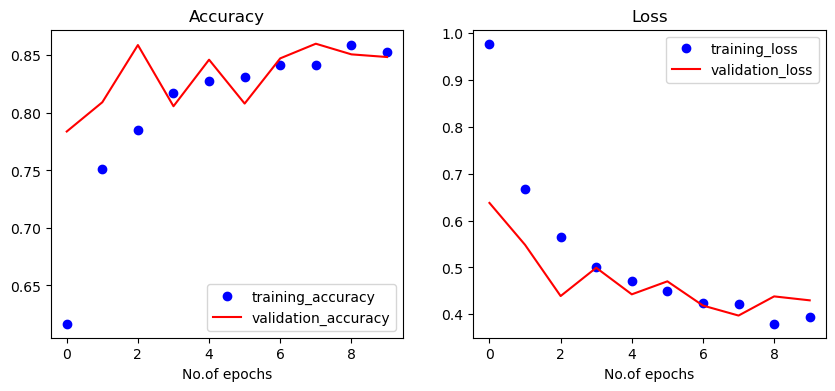

In [41]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],'bo')
plt.plot(hist.history['val_accuracy'],'r')
plt.xlabel('No.of epochs')
plt.title('Accuracy')
plt.legend(['training_accuracy','validation_accuracy'],loc='best')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], 'bo')
plt.plot(hist.history['val_loss'],'r')
plt.xlabel('No.of epochs')
plt.title('Loss')
plt.legend(['training_loss','validation_loss'])
plt.show()

### Observation

<b> The pretrained VGG16 model performance is slightly lesser than the complex model we built.

<b> With a training accuracy of 87% and test accuracy of 85%

## 2) RESNET

In [43]:
# Loading the pre trained RESNET model
img_height,img_width = 224, 224 
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

K.clear_session()

x = base_model.output
x = GlobalAveragePooling2D()(x)
# Dropout regularization
x = Dropout(0.8)(x) 
# Dense layer with L2 regularizer
x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
predictions = Dense(5, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [44]:
hist = model.fit(train_gen, epochs = 10, validation_data = test_gen)

Epoch 1/10
108/108 [==============================] - 59s 481ms/step - loss: 13.8979 - accuracy: 0.6967 - val_loss: 16.0098 - val_accuracy: 0.2439
Epoch 2/10
108/108 [==============================] - 50s 467ms/step - loss: 12.0337 - accuracy: 0.8804 - val_loss: 12.6533 - val_accuracy: 0.1769
Epoch 3/10
108/108 [==============================] - 51s 467ms/step - loss: 10.4524 - accuracy: 0.9102 - val_loss: 11.3024 - val_accuracy: 0.2497
Epoch 4/10
108/108 [==============================] - 51s 472ms/step - loss: 8.9385 - accuracy: 0.9415 - val_loss: 9.8110 - val_accuracy: 0.3468
Epoch 5/10
108/108 [==============================] - 50s 465ms/step - loss: 7.5848 - accuracy: 0.9510 - val_loss: 7.9438 - val_accuracy: 0.5538
Epoch 6/10
108/108 [==============================] - 51s 470ms/step - loss: 6.3774 - accuracy: 0.9571 - val_loss: 6.5563 - val_accuracy: 0.7168
Epoch 7/10
108/108 [==============================] - 51s 468ms/step - loss: 5.3376 - accuracy: 0.9609 - val_loss: 5.4794 - 

In [45]:
# evaluate the performance the new model and report the results
score = model.evaluate(test_gen)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

28/28 [==============================] - 3s 116ms/step - loss: 2.9787 - accuracy: 0.9202
Test Score: 2.9786925315856934
Test Accuracy: 0.9202312231063843


## Testing for accuracy

In [46]:
y_test = test_gen.classes

yt_prob = model.predict(test_gen)
yt_pred = np.argmax(yt_prob, axis=1)

28/28 [==============================] - 4s 115ms/step


In [47]:
confusion_matrix(y_test, yt_pred)

array([[131,  10,   6,   2,   4],
       [  3, 199,   1,   2,   6],
       [  0,   1, 144,   0,  12],
       [  1,   5,   2, 136,   3],
       [  1,   2,   8,   0, 186]])

In [48]:
accuracy_score(y_test, yt_pred)

0.9202312138728324

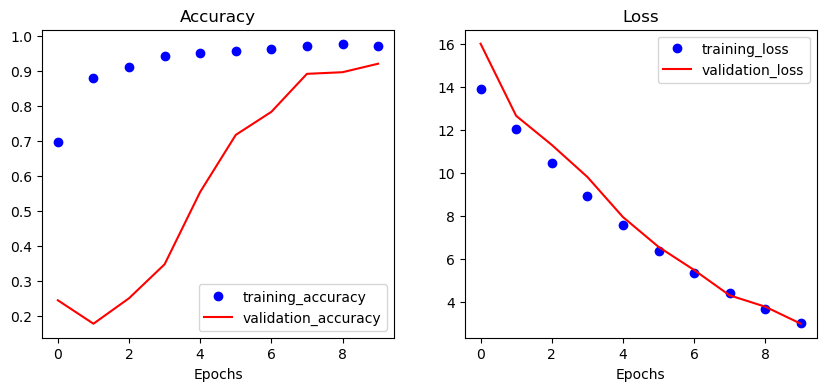

In [49]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'],'bo')
plt.plot(hist.history['val_accuracy'],'r')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend(['training_accuracy','validation_accuracy'],loc='best')
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], 'bo')
plt.plot(hist.history['val_loss'],'r')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend(['training_loss','validation_loss'])
plt.show()

## Taking a sunflower image and checking the classification of model

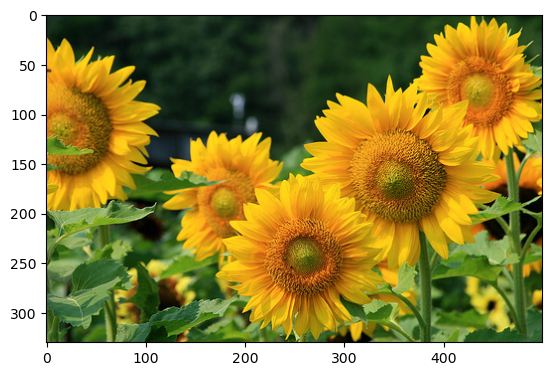

In [50]:
from tensorflow.keras.utils import load_img
test_image = load_img('/kaggle/input/flowers-recognition/flowers/sunflower/1008566138_6927679c8a.jpg')
plt.imshow(test_image)
plt.show()

In [51]:
train_gen.class_indices.keys()

dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

In [53]:
# Load the test image
test_image = image.load_img('/kaggle/input/flowers-recognition/flowers/sunflower/1008566138_6927679c8a.jpg', target_size=(img_size, img_size))

# Convert the test image to an array
test_image = image.img_to_array(test_image)

# Reshape the test image
test_image = test_image.reshape(1, img_size, img_size, 3)

# Normalize the test image
test_image = test_image / 255.0

# Make a prediction
result = model.predict(test_image)

# Get the predicted class
predicted_class = np.argmax(result)

# Map the predicted class to the class label
class_labels = train_gen.class_indices
prediction = [k for k, v in class_labels.items() if v == predicted_class][0]

# Print the predicted class
print('Prediction: ', prediction)


1/1 [==============================] - 1s 945ms/step
Prediction:  sunflower


<b> Model predicted the sunflower correctly

###  Conclusion

<b> Among all the models, the performance of a pretrained RESNET model with 10 epochs is really good.

<b> Training accuracy of RESNET model is 97 % whereas the test accuracy is over 92%.